# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

После того, как модель починилась, нужно повторить на нескольких разных
датасетах.

## Задачи

- `DONE` Повторять на двух датасетах
- `DONE` Избавиться от dabs_mean_std
- `DONE` На каждом графике отображать его датасет
- `TODO` Повторять на трёх датасетах
- `TODO` Сохранить $\mathrm{loss}(\mathrm{epoch})$ в виде графика и JSON
- `TODO` Сохранить $\mathrm{metric}(\mathrm{noise})$ в виде графика и JSON
- `TODO` $P$ in $[0, 0.01, 0.05, 0.5, 0.9, 0.99]$
- `TODO` Каждый эксперимент повторяется 10 раз
- `TODO` Результат получен, всё упаковано и подписано

In [14]:
BATCH_SIZE = 12
EPOCHS = 10
LEARNING_RATE = 0.00011
P = 0.05

n = 50
NOISE_FACTORS = [
    x * 2/n for x in range(n)
    # 0, 1, 3, 5, 8,
    # 10, 30, 50, 60, 70, 80,
    # 100, 300, 500, 600, 700, 800,
    # 1000, 3000, 5000,
    # 10000, 30000, 50000,
]

In [15]:
pip install torch torchvision pandas scikit-learn 'numpy<2'


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Данные

In [16]:
import time
from typing import List, Tuple
from datetime import datetime

datetime_now = datetime.now()
time_now = time.time()

import urllib.request
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

import sys
with open('log.txt', 'a') as file:
    file.write(f'{datetime.now().isoformat()} A {sys.argv[0]} is {time.time() - time_now}\n')

TEST_SIZE = 0.2
RANDOM_STATE = 23432

def download_csv(
    url: str,
    saved_name: str,
    features: List[str] = None
) -> pd.DataFrame:
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)
    file_path = os.path.join(data_dir, saved_name)

    urllib.request.urlretrieve(url, file_path)

    if features is None:
        return pd.read_csv(file_path)
    else:
        return pd.read_csv(file_path, header=None, names=features)

def dataset_from_dataframe(
    df: pd.DataFrame,
    target: str,
    y_dtype: type
) -> TensorDataset:
    X = df.drop(columns=[target]).values
    y = df[target].values

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=y_dtype)

    return TensorDataset(X_tensor, y_tensor)

In [17]:


def breast_cancer_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/dataspelunking/MLwR/refs/heads/master/Machine%20Learning%20with%20R%20(2nd%20Ed.)/Chapter%2003/wisc_bc_data.csv',
        saved_name='wisc_bc_data.csv'
    )

    target = 'diagnosis'

    df[target] = df[target].map({ 'M': 0, 'B': 1 })
    df = df.drop(columns=['id'])

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    # Классификация
    y_dtype = torch.long

    return (
        dataset_from_dataframe(train_df, target, y_dtype),
        dataset_from_dataframe(val_df, target, y_dtype)
    )

In [18]:


def car_evaluation_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/mragpavank/car-evaluation-dataset/refs/heads/master/car_evaluation.csv',
        saved_name='car_evaluation.csv',
        features=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    )


    df['class'] = df['class'].map({
        'unacc': 0,
        'acc': 1,
        'good': 2,
        'vgood': 3,
    })

    df['doors'] = df['doors'].map({
        '2': 2,
        '3': 3,
        '4': 4,
        '5more': 5
    })

    high_map = {
        'low': 0,
        'med': 1,
        'high': 2,
        'vhigh': 3
    }

    df['buying'] = df['buying'].map(high_map)
    df['safety'] = df['safety'].map(high_map)
    df['maint'] = df['maint'].map(high_map)

    df['persons'] = df['persons'].map({
        '2': 2,
        '4': 4,
        'more': 6
    })

    df['lug_boot'] = df['lug_boot'].map({
        'small': 0,
        'med': 1,
        'big': 2
    })

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )


    target = 'class'

    return (
        dataset_from_dataframe(train_df, target),
        dataset_from_dataframe(val_df, target)
    )

In [19]:

def student_performance_factors_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = pd.read_csv('data/StudentPerformanceFactors.csv')

    lmh = {
        'Low': -1,
        'Medium': 0,
        'High': +1,
    }

    yn = {
        'Yes': +1,
        'No': -1,
    }

    df = df.dropna(subset=['Teacher_Quality'])

    df['Parental_Involvement'] = df['Parental_Involvement'].map(lmh)
    df['Access_to_Resources'] = df['Access_to_Resources'].map(lmh)
    df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(yn)
    df['Motivation_Level'] = df['Motivation_Level'].map(lmh)
    df['Internet_Access'] = df['Internet_Access'].map(yn)
    df['Family_Income'] = df['Family_Income'].map(lmh)
    df['Teacher_Quality'] = df['Teacher_Quality'].map(lmh)
    df['School_Type'] = df['School_Type'].map({
        'Public': +1,
        'Private': -1,
    })
    df['Peer_Influence'] = df['Peer_Influence'].map({
        'Positive': +1,
        'Neutral': 0,
        'Negative': -1,
    })
    df['Learning_Disabilities'] = df['Learning_Disabilities'].map(yn)
    df['Parental_Education_Level'] = df['Parental_Education_Level'].map({
        'Postgraduate': +3,
        'College': +2,
        'High School': +1,
    }).fillna(0)
    df['Distance_from_Home'] = df['Distance_from_Home'].map({
        'Near': +1,
        'Moderate': 0,
        'Far': -1,
    }).fillna(0)
    df['Gender'] = df['Gender'].map({
        'Female': +1,
        'Male': -1,
    }).fillna(0)

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    target = 'Exam_Score'

    # Регрессия
    y_dtype = torch.float

    return (
        dataset_from_dataframe(train_df, target, y_dtype),
        dataset_from_dataframe(val_df, target, y_dtype)
    )

In [20]:
from dataclasses import dataclass

import pandas as pd
from torch.utils.data import DataLoader


@dataclass
class Dataset:
    name: str
    features_count: int
    classes_count: int
    train_dataset: pd.DataFrame
    test_dataset: pd.DataFrame
    train_loader: DataLoader
    test_loader: DataLoader


In [21]:

from torch.utils.data import DataLoader

def make_dataset1(batch_size: int) -> Dataset:
    train_dataset, test_dataset = breast_cancer_dataset()
    BATCH_SIZE

    return Dataset(
        name='wisc_bc_data.csv',
        features_count=train_dataset[1][0].shape[0],
        classes_count=2,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )

def make_dataset2(batch_size: int) -> Dataset:
    train_dataset, test_dataset = car_evaluation_dataset()

    return Dataset(
        name='car_evaluation.csv',
        features_count=train_dataset[1][0].shape[0],
        classes_count=4,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )

def make_dataset3(batch_size: int) -> Dataset:
    train_dataset, test_dataset = student_performance_factors_dataset()

    return Dataset(
        name='StudentPerformanceFactors.csv',
        features_count=train_dataset[1][0].shape[0],
        classes_count=1,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )


datasets = make_dataset3(batch_size=BATCH_SIZE)




## Модели

In [22]:


import torch

class CustomBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для линейного слоя.
    """
    @staticmethod
    def forward(
        ctx,
        p: float,
        input: torch.Tensor,
        weight: torch.Tensor,
        bias: float = None
    ):
        ctx.save_for_backward(torch.scalar_tensor(p), input, weight, bias)

        output = input.mm(weight.t())
        if bias is not None:
            output += bias

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input, weight, bias = ctx.saved_tensors

        height = weight.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
 
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        grad_output = grad_output.mm(diagonal_mask)

        grad_input = grad_output.mm(weight)
        grad_weight = grad_output.t().mm(input)

        if bias is not None:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return None, grad_input, grad_weight, grad_bias

class CustomReLUBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для слоя ReLU.
    """
    @staticmethod
    def forward(ctx, p: float, input: torch.Tensor):
        ctx.save_for_backward(torch.scalar_tensor(p), input)
        return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input = ctx.saved_tensors

        grad_output = grad_output * (input > 0).float()

        # У матриц ось 0 это Y
        height = grad_output.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        diagonal_mask = diagonal_mask.unsqueeze(1).expand(-1, grad_output.size(1), -1)
        diagonal_mask = diagonal_mask.permute(0, 2, 1)

        grad_output = grad_output.unsqueeze(1) * diagonal_mask
        grad_output = grad_output.sum(dim=1)

        return None, grad_output

    
class CustomReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, p: float):
        ctx.save_for_backward(input, torch.scalar_tensor(p))
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, p, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= 0] = 0

        # У матриц ось 0 это Y
        bernoulli_mask = torch.bernoulli(torch.ones(grad_input.size(0)) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item()+1e-5)
        
        # Multiply grad_input with the diagonal matrix
        grad_input = diagonal_mask @ grad_input
        
        return grad_input, None
    
    
class CustomReLULayer(torch.nn.Module):
    def __init__(self, p: float):
        super(CustomReLULayer, self).__init__()
        self.p = p
        self.custom_relu_backward = CustomReLUFunction.apply

    def forward(self, x):
        return self.custom_relu_backward(x, self.p)

In [23]:


import torch.nn as nn
import torch.nn.functional as F

class RegularNetwork(nn.Module):
    """
    Нейросеть с обычными линейными слоями. Параметр `p` игнорируется.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(RegularNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class AugmentedLinearNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для линейных слоёв.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.p = p

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(self.p, x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(self.p, x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class AugmentedReLUNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для функции активации.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_relu1 = CustomReLULayer(p)
        self.custom_relu2 = CustomReLULayer(p)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.custom_relu1(x)
        x = self.fc2(x)
        x = self.custom_relu2(x)
        x = self.fc3(x)
        return x



## Обучение

In [24]:
import torch

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
):
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())

In [25]:
import torch.optim as optim
import matplotlib.pyplot as plt

import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def train(
    model: RegularNetwork, 
    dataset: Dataset,
    epochs: int,
    criterion,
    optimizer
):
    # Наблюдаемые величины
    running_losses: list[float] = []
    fc1_dabs_mean: list[float] = []
    fc1_dabs_std: list[float] = []
    fc2_dabs_mean: list[float] = []
    fc2_dabs_std: list[float] = []
    fc3_dabs_mean: list[float] = []
    fc3_dabs_std: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(dataset.train_loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            fc1_weight = model.fc1.weight.clone()
            fc2_weight = model.fc2.weight.clone()
            fc3_weight = model.fc3.weight.clone()

            optimizer.step()

            running_loss += loss.item()

            #if i % 2 == 1:
            if True:
                (mean1, std1) = (dabs_mean_std(fc1_weight, model.fc1.weight))
                fc1_dabs_mean.append(mean1)
                fc1_dabs_std.append(std1)

                (mean2, std2) = (dabs_mean_std(fc2_weight, model.fc2.weight))
                fc2_dabs_mean.append(mean2)
                fc2_dabs_std.append(std2)

                (mean3, std3) = (dabs_mean_std(fc3_weight, model.fc3.weight))
                fc3_dabs_mean.append(mean3)
                fc3_dabs_std.append(std3)

                print(f'E{epoch + 1}/{epochs} S{i + 1}/{len(dataset.train_loader)} Loss={running_loss / 100:.4f}')
                running_losses.append(running_loss)
                running_loss = 0.0

    X = range(len(fc1_dabs_mean))

    def plot_mean_std(label, color, series_mean, series_std):
        plt.plot(X, series_mean, label=label, color=color)

        plt.fill_between(
            X,
            [m - s for m, s in zip(series_mean, series_std)],
            [m + s for m, s in zip(series_mean, series_std)],
            color=color,
            alpha=0.2
        )

    # Plot absolute means of gradients

    # plt.figure(figsize=(10, 6))
    # plot_mean_std('FC1 abs mean gradient', 'blue', fc1_dabs_mean, fc1_dabs_std)
    # plot_mean_std('FC2 abs mean gradient', 'green', fc2_dabs_mean, fc2_dabs_std)
    # plot_mean_std('FC3 abs mean gradient', 'red', fc3_dabs_mean, fc3_dabs_std)
    # plt.title(f'Absolute mean gradients of layers: {model.__class__.__name__}')
    # plt.legend()
    # plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(X, running_losses, label='Running loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'Loss curve: {model.__class__.__name__} on {dataset.name}')
    plt.legend()
    plt.show()


E1/10 S1/38 Loss=0.0185
E1/10 S2/38 Loss=0.3730
E1/10 S3/38 Loss=0.0863
E1/10 S4/38 Loss=0.0344
E1/10 S5/38 Loss=0.1141
E1/10 S6/38 Loss=0.2614
E1/10 S7/38 Loss=0.0921
E1/10 S8/38 Loss=0.1404
E1/10 S9/38 Loss=0.0099
E1/10 S10/38 Loss=0.0170
E1/10 S11/38 Loss=0.1806
E1/10 S12/38 Loss=0.1200
E1/10 S13/38 Loss=0.1037
E1/10 S14/38 Loss=0.0000
E1/10 S15/38 Loss=0.0148
E1/10 S16/38 Loss=0.0466
E1/10 S17/38 Loss=0.0749
E1/10 S18/38 Loss=0.0640
E1/10 S19/38 Loss=0.0208
E1/10 S20/38 Loss=0.0230
E1/10 S21/38 Loss=0.0207
E1/10 S22/38 Loss=0.0468
E1/10 S23/38 Loss=0.0001
E1/10 S24/38 Loss=0.0042
E1/10 S25/38 Loss=0.0499
E1/10 S26/38 Loss=0.0162
E1/10 S27/38 Loss=0.0437
E1/10 S28/38 Loss=0.0030
E1/10 S29/38 Loss=0.0031
E1/10 S30/38 Loss=0.0286
E1/10 S31/38 Loss=0.0069
E1/10 S32/38 Loss=0.0182
E1/10 S33/38 Loss=0.0020
E1/10 S34/38 Loss=0.0007
E1/10 S35/38 Loss=0.0036
E1/10 S36/38 Loss=0.0531
E1/10 S37/38 Loss=0.0091
E1/10 S38/38 Loss=0.0000
E2/10 S1/38 Loss=0.0159
E2/10 S2/38 Loss=0.0062
E2/10 S3/38

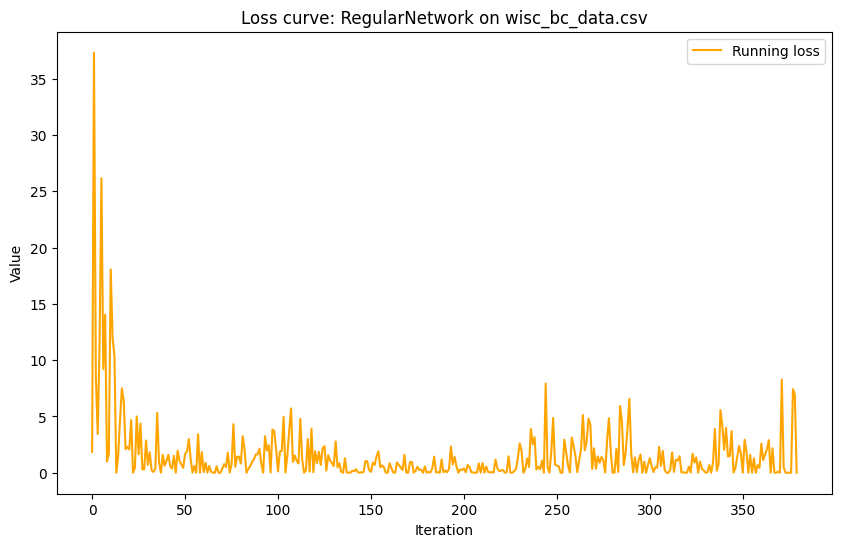

E1/10 S1/38 Loss=0.1005
E1/10 S2/38 Loss=0.0254
E1/10 S3/38 Loss=0.0276
E1/10 S4/38 Loss=0.1639
E1/10 S5/38 Loss=0.1574
E1/10 S6/38 Loss=0.0343
E1/10 S7/38 Loss=0.1123
E1/10 S8/38 Loss=0.1275
E1/10 S9/38 Loss=0.0506
E1/10 S10/38 Loss=0.0366
E1/10 S11/38 Loss=0.0060
E1/10 S12/38 Loss=0.0338
E1/10 S13/38 Loss=0.0111
E1/10 S14/38 Loss=0.0108
E1/10 S15/38 Loss=0.0106
E1/10 S16/38 Loss=0.0024
E1/10 S17/38 Loss=0.0183
E1/10 S18/38 Loss=0.0003
E1/10 S19/38 Loss=0.0065
E1/10 S20/38 Loss=0.0044
E1/10 S21/38 Loss=0.0021
E1/10 S22/38 Loss=0.0097
E1/10 S23/38 Loss=0.0069
E1/10 S24/38 Loss=0.0039
E1/10 S25/38 Loss=0.0014
E1/10 S26/38 Loss=0.0082
E1/10 S27/38 Loss=0.0042
E1/10 S28/38 Loss=0.0003
E1/10 S29/38 Loss=0.0140
E1/10 S30/38 Loss=0.0005
E1/10 S31/38 Loss=0.0019
E1/10 S32/38 Loss=0.0079
E1/10 S33/38 Loss=0.0103
E1/10 S34/38 Loss=0.0000
E1/10 S35/38 Loss=0.0000
E1/10 S36/38 Loss=0.0143
E1/10 S37/38 Loss=0.0004
E1/10 S38/38 Loss=0.0031
E2/10 S1/38 Loss=0.0170
E2/10 S2/38 Loss=0.0005
E2/10 S3/38

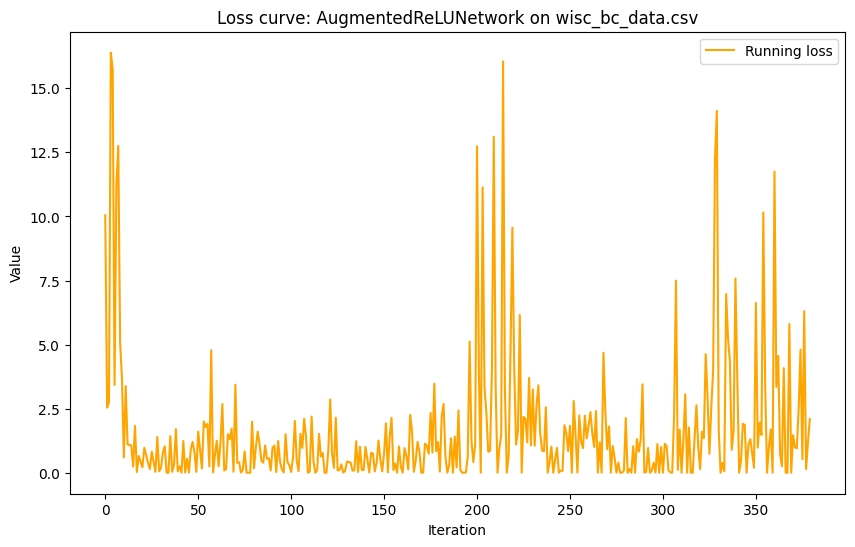

/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E1/10 S1/436 Loss=40.9839
E1/10 S2/436 Loss=36.1531
E1/10 S3/436 Loss=29.2247
E1/10 S4/436 Loss=25.4656
E1/10 S5/436 Loss=19.6074
E1/10 S6/436 Loss=15.2172
E1/10 S7/436 Loss=10.2443
E1/10 S8/436 Loss=8.6904
E1/10 S9/436 Loss=10.1596
E1/10 S10/436 Loss=6.1038
E1/10 S11/436 Loss=2.5732
E1/10 S12/436 Loss=1.6173
E1/10 S13/436 Loss=1.2891
E1/10 S14/436 Loss=0.7804
E1/10 S15/436 Loss=0.6796
E1/10 S16/436 Loss=0.7320
E1/10 S17/436 Loss=1.3268
E1/10 S18/436 Loss=1.7812
E1/10 S19/436 Loss=1.6676
E1/10 S20/436 Loss=2.4815
E1/10 S21/436 Loss=1.8539
E1/10 S22/436 Loss=2.8922
E1/10 S23/436 Loss=2.7482
E1/10 S24/436 Loss=2.2596
E1/10 S25/436 Loss=1.8927
E1/10 S26/436 Loss=1.4688
E1/10 S27/436 Loss=2.1818
E1/10 S28/436 Loss=2.0828
E1/10 S29/436 Loss=1.3195
E1/10 S30/436 Loss=1.6664
E1/10 S31/436 Loss=2.1447
E1/10 S32/436 Loss=0.8632
E1/10 S33/436 Loss=0.7569
E1/10 S34/436 Loss=0.7341
E1/10 S35/436 Loss=0.5569
E1/10 S36/436 Loss=0.3468
E1/10 S37/436 Loss=0.7955
E1/10 S38/436 Loss=0.8986
E1/10 S39/436

/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E2/10 S38/436 Loss=0.9278
E2/10 S39/436 Loss=0.4001
E2/10 S40/436 Loss=0.3457
E2/10 S41/436 Loss=0.4442
E2/10 S42/436 Loss=0.5562
E2/10 S43/436 Loss=0.4328
E2/10 S44/436 Loss=0.4944
E2/10 S45/436 Loss=0.4687
E2/10 S46/436 Loss=0.4234
E2/10 S47/436 Loss=0.8055
E2/10 S48/436 Loss=0.4041
E2/10 S49/436 Loss=0.3228
E2/10 S50/436 Loss=0.2172
E2/10 S51/436 Loss=0.7308
E2/10 S52/436 Loss=0.5384
E2/10 S53/436 Loss=0.5186
E2/10 S54/436 Loss=0.6861
E2/10 S55/436 Loss=0.5017
E2/10 S56/436 Loss=0.7717
E2/10 S57/436 Loss=0.7073
E2/10 S58/436 Loss=0.3030
E2/10 S59/436 Loss=0.2506
E2/10 S60/436 Loss=0.5685
E2/10 S61/436 Loss=0.5546
E2/10 S62/436 Loss=0.6976
E2/10 S63/436 Loss=1.4506
E2/10 S64/436 Loss=0.5076
E2/10 S65/436 Loss=0.6069
E2/10 S66/436 Loss=0.5857
E2/10 S67/436 Loss=0.2737
E2/10 S68/436 Loss=0.6548
E2/10 S69/436 Loss=0.5704
E2/10 S70/436 Loss=0.5163
E2/10 S71/436 Loss=0.3399
E2/10 S72/436 Loss=0.4037
E2/10 S73/436 Loss=0.7340
E2/10 S74/436 Loss=0.5555
E2/10 S75/436 Loss=0.3924
E2/10 S76/43

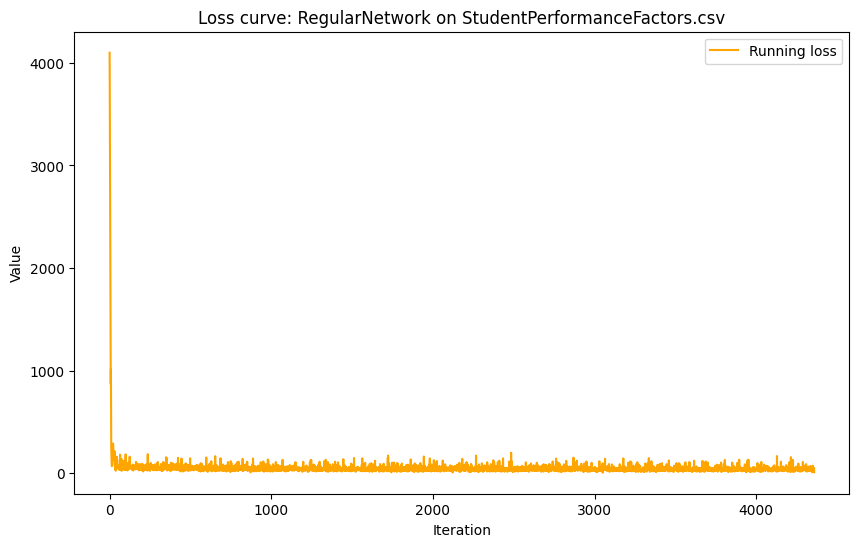

E1/10 S1/436 Loss=50.0088
E1/10 S2/436 Loss=46.6262
E1/10 S3/436 Loss=36.8051
E1/10 S4/436 Loss=31.9686
E1/10 S5/436 Loss=29.2543
E1/10 S6/436 Loss=23.0443
E1/10 S7/436 Loss=19.8267
E1/10 S8/436 Loss=15.7772
E1/10 S9/436 Loss=12.5600
E1/10 S10/436 Loss=10.7731
E1/10 S11/436 Loss=9.7690
E1/10 S12/436 Loss=6.7168
E1/10 S13/436 Loss=4.8183
E1/10 S14/436 Loss=5.2007
E1/10 S15/436 Loss=2.0212
E1/10 S16/436 Loss=2.0463
E1/10 S17/436 Loss=0.9828
E1/10 S18/436 Loss=0.4048
E1/10 S19/436 Loss=0.7535
E1/10 S20/436 Loss=1.0668
E1/10 S21/436 Loss=1.0950
E1/10 S22/436 Loss=0.5189
E1/10 S23/436 Loss=0.5482
E1/10 S24/436 Loss=1.2278
E1/10 S25/436 Loss=1.7320
E1/10 S26/436 Loss=0.8280
E1/10 S27/436 Loss=1.3134
E1/10 S28/436 Loss=1.4383
E1/10 S29/436 Loss=1.9081
E1/10 S30/436 Loss=1.7799
E1/10 S31/436 Loss=1.8121
E1/10 S32/436 Loss=1.6024
E1/10 S33/436 Loss=1.8612
E1/10 S34/436 Loss=0.9957
E1/10 S35/436 Loss=1.1650
E1/10 S36/436 Loss=0.6368
E1/10 S37/436 Loss=1.5301
E1/10 S38/436 Loss=1.9086
E1/10 S39/4

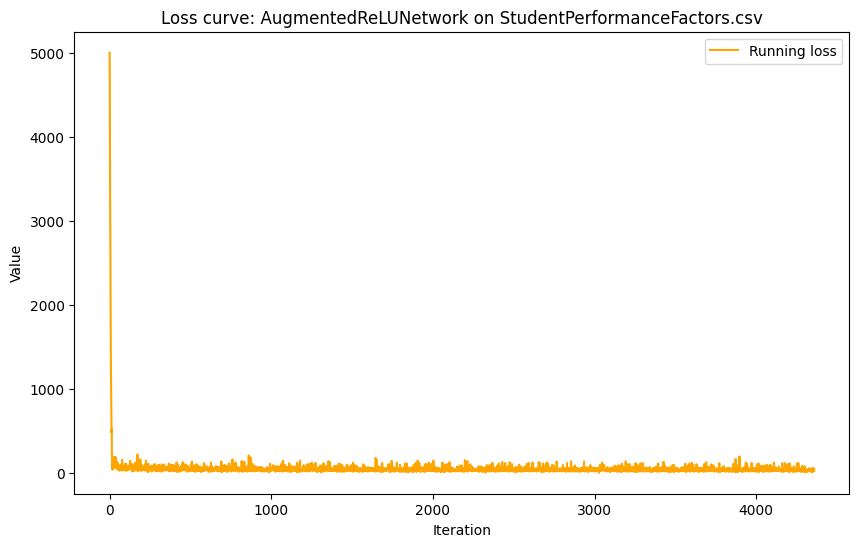

In [26]:

def train_pair_of_networks(
    criterion: nn.CrossEntropyLoss | nn.MSELoss,
    dataset: Dataset,
    learning_rate: float,
    epochs: int,
    model_a_name: str,
    model_b_name: str
):
    modelA = RegularNetwork(
        inputs_count=dataset.features_count,
        outputs_count=dataset.classes_count,
        p = P
    )

    modelA.apply(init_weights)

    train(
        model=modelA,
        dataset=dataset,
        epochs=epochs,
        criterion=criterion,
        optimizer=optim.Adam(
            modelA.parameters(),
            lr=learning_rate
        )
    )

    torch.save(modelA.state_dict(), model_a_name)

    modelB = AugmentedReLUNetwork(
        inputs_count=dataset.features_count,
        outputs_count=dataset.classes_count,
        p = P
    )

    modelB.apply(init_weights)

    train(
        model=modelB,
        dataset=dataset,
        epochs=epochs,
        criterion=criterion,
        optimizer=optim.Adam(
            modelB.parameters(),
            lr=learning_rate
        )
    )


    torch.save(modelB.state_dict(), model_b_name)

classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.MSELoss()

train_pair_of_networks(
    classification_criterion,
    make_dataset1(batch_size=BATCH_SIZE),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_a_name='model-1A-c.pth',
    model_b_name='model-1B-c.pth'
)

train_pair_of_networks(
    regression_criterion,
    make_dataset3(batch_size=BATCH_SIZE),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_a_name='model-3A-r.pth',
    model_b_name='model-3B-r.pth'
)


In [27]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, r2_score, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def positive_probs_from(probs: torch.Tensor) -> list:
    return np.array(probs)[:, 0]

def evaluate_classification_model(
    dataset: Dataset,
    path: str,
    constructor: type,
    noise_factor: float,
    is_binary_classification: bool,
    inputs_count: int,
    outputs_count: int
):
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count,
        p=P
    )

    evaluated_model.load_state_dict(torch.load(path))

    evaluated_model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataset.test_loader:
            outputs = evaluated_model(
                inputs + torch.randn(inputs.shape) * noise_factor
            )
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if is_binary_classification:
        all_probs = np.array(all_probs)[:, 0]

    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return accuracy, f1, roc_auc

def evaluate_regression_model(
    dataset: Dataset,
    model_path: str,
    constructor: type,
    noise_factor: float,
    inputs_count: int,
    outputs_count: int
):
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count,
        p=P
    )

    evaluated_model.load_state_dict(torch.load(model_path))

    evaluated_model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataset.test_loader:
            noisy_inputs = inputs + torch.randn(inputs.shape) * noise_factor
            outputs = evaluated_model(noisy_inputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    r2 = r2_score(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)

    return r2, mse

def evaluate_model(
    dataset: Dataset,
    model_path: str,
    constructor: type,
    is_binary_classification: bool,
    is_regression: bool,
    inputs_count: int,
    outputs_count: int
):
    if is_regression:
        samples = {
            'noise_factor': NOISE_FACTORS,
            'r2': [],
            'mse': [],
        }

        for noise_factor in NOISE_FACTORS:
            r2, mse = evaluate_regression_model(
                dataset=dataset,
                model_path=model_path,
                constructor=constructor,
                noise_factor=noise_factor,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['r2'].append(r2)
            samples['mse'].append(mse)

        return pd.DataFrame(samples)
    else:
        samples = {
            'noise_factor': NOISE_FACTORS,
            'accuracy': [],
            'f1': [],
            'roc_auc': [],
        }

        for noise_factor in NOISE_FACTORS:
            accuracy, f1, roc_auc = evaluate_classification_model(
                dataset=dataset,
                path=model_path,
                constructor=constructor,
                noise_factor=noise_factor,
                is_binary_classification=is_binary_classification,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['accuracy'].append(accuracy)
            samples['f1'].append(f1)
            samples['roc_auc'].append(roc_auc)

        return pd.DataFrame(samples)

def plot_evaluation_of_classification(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['accuracy'], label='Accuracy', marker='o')
    plt.plot(df['noise_factor'], df['f1'], label='F1 Score', marker='o')
    plt.plot(df['noise_factor'], df['roc_auc'], label='ROC AUC', marker='o')

    plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor: {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

# XXX split into two..
def plot_evaluation_of_regression(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['mse'], label='Mean Square Error', marker='o')

    # plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor: {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")

    plt.show()

    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['r2'], label='R^2', marker='o')

    # plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

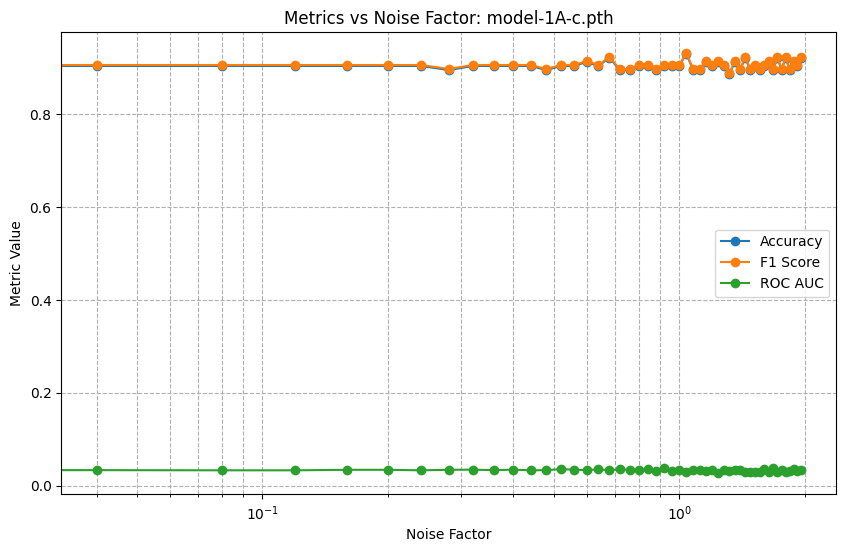

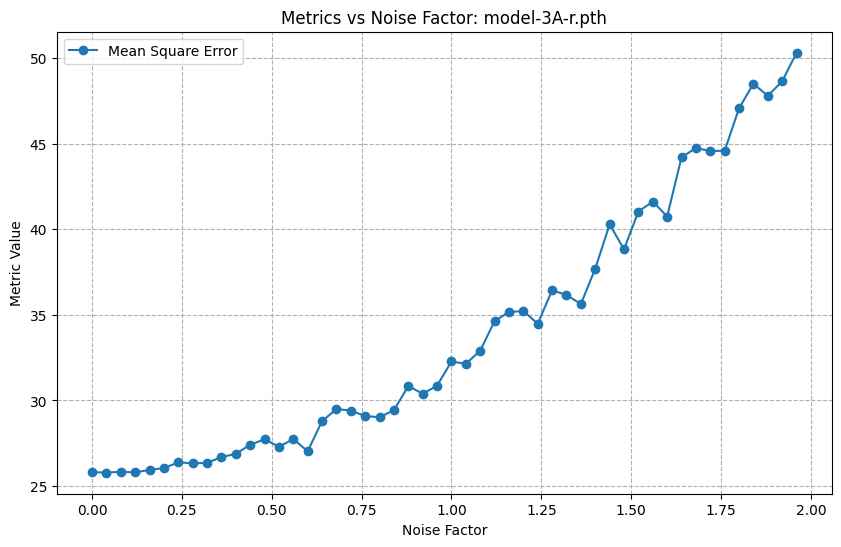

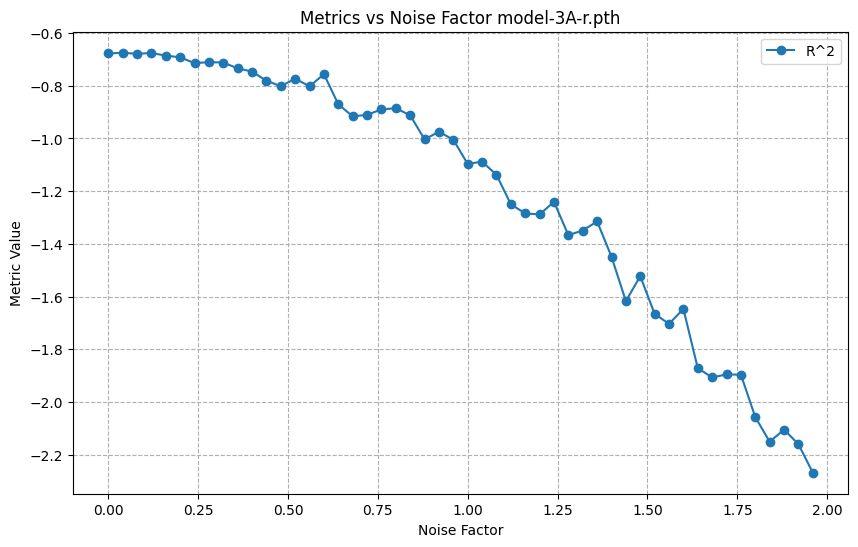

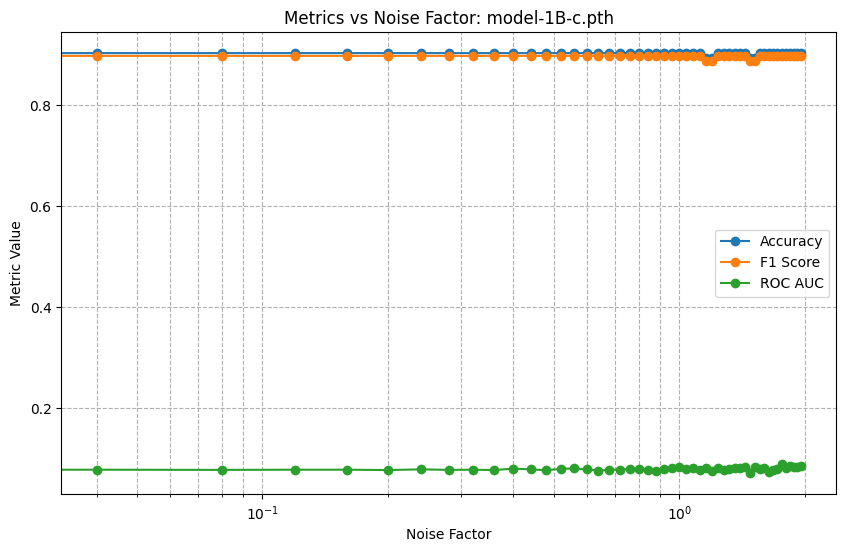

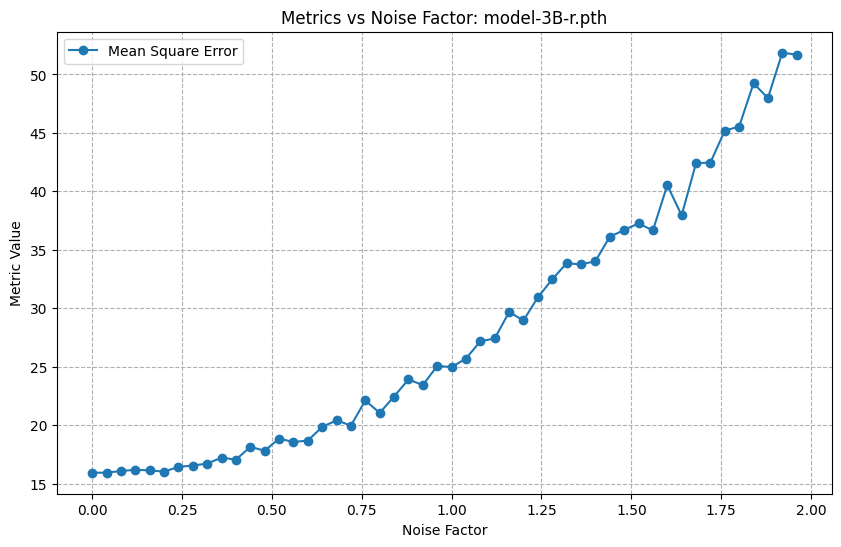

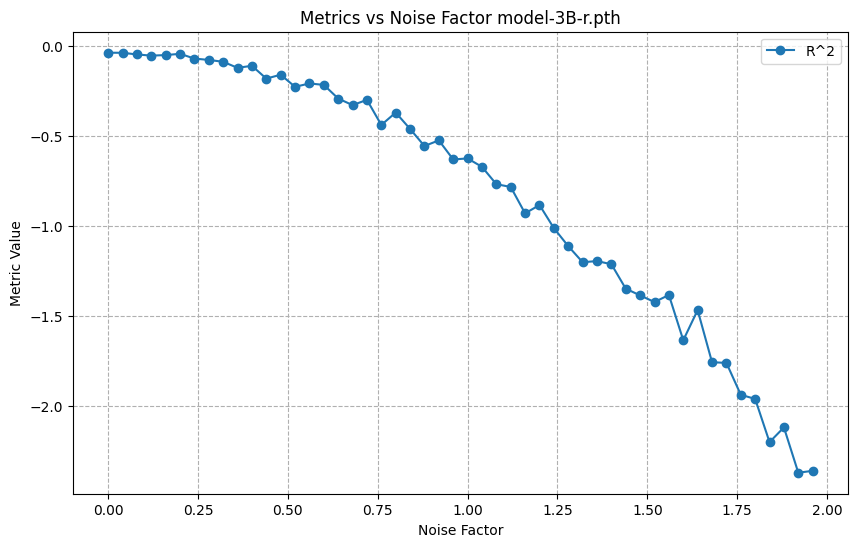

In [28]:
def eval(model_a_or_b: str, constructor: type):
    model_path=f"model-1{model_a_or_b}-c.pth"
    plot_evaluation_of_classification(evaluate_model(
        dataset=make_dataset1(batch_size=BATCH_SIZE),
        model_path=model_path,
        constructor=constructor,
        is_binary_classification=True,
        is_regression=False,
        inputs_count=30,
        outputs_count=2
    ), title=model_path)

    model_path=f"model-3{model_a_or_b}-r.pth"
    plot_evaluation_of_regression(evaluate_model(
        dataset=make_dataset3(batch_size=BATCH_SIZE),
        model_path=model_path,
        constructor=constructor,
        is_binary_classification=False,
        is_regression=True,
        inputs_count=19,
        outputs_count=1
    ), title=model_path)

eval('A', RegularNetwork)
eval('B', AugmentedReLUNetwork)